<a href="https://colab.research.google.com/github/LukaPavlovicGit/Concurrent-Algorithms/blob/main/Projekat_3_CUDA_programing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paralelni algoritmi - Treći projekat

- Projekat se radi individualno ili u paru

- Rok za predaju projekata je **sreda 11.01.2023, do kraja dana (23:59)**. 

- Odbrane će biti organizovane u toku kolokvijumske nedelje.

- Predaja projekata je putem e-maila, programski kod bi trebalo da
bude prikacen uz sam e-mail. Subject e-maila treba da bude u formatu
"[RN3RA Projekat 1] Prezime (Prezime ukoliko se radi u paru)". Tekst e-maila treba da bude u formi:
"Ime Prezime XX/GGRN" (gde su XX i GG broje indeksa i godina upisa).
Link ka Collab-u je opcion. Ukoliko dva
studenta rade u paru, dovoljno je da jedan od njih preda, pri cemu
drugog stavi u cc.

## Smith–Waterman algoritam

Smith–Waterman je algoritam za poravnavanje sekvenci baziran na principima dinamičkog programiranja. Za date dve sekvence A i B i parametre poravnanja `match`, `miss` i `gap` popunjava se matrica dimenzija $|A| \times |B|$, tako što postavljamo $$M_{ij} = max \begin{cases} {M_{i-1, j-1} + score(A_i, B_i)} \\ {M_{i-1, j} - gap}\\ {M_{i, j-1} - gap}\\ 0 \end{cases}$$ pri čemu je: $$score(A_i, B_i) = \begin{cases} {match \quad \text{ ako je } A_i = B_i }\\ {-miss \quad \text {ako je }A_i \neq B_i } \end{cases}$$

Sve vrednosti u prvom redu i prvoj koloni su 0. Optimalna vrednost poravnanja je najveća vrednost u matrici.

U klasičnoj implementaciji matrica se popunjava sekvencijalno  po kolonama ili po redovima (slika 1).   

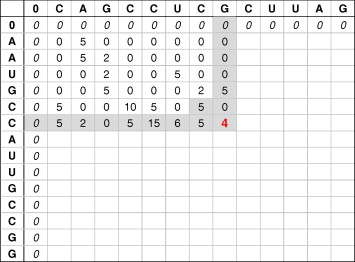  
Slika 1: Smith–Waterman matrica

Zadatak ovog projekta je alternativna implementacija opisana u [Wozniak, 1997](https://academic.oup.com/bioinformatics/article/13/2/145/248735?login=false) kod koje se matrica popunjava dijagonalno (slika 2), što omogaćava da se veći broj vrednosti računa u paraleli.  

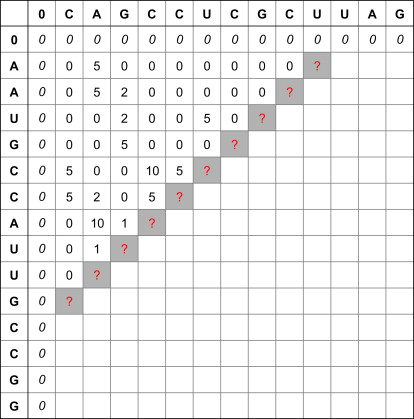  
Slika 2: Popunavanja po dijagonali

### 1. CUDA paralelna implementacija izačuavanja matrice [7 bodova]

Koristeći jezik CUDA (opciono kroz pyCUDA okruženje) implementriati dijagonalno popunavanje Smith-Watrman matrice poravnanja. Pretpostaviti da su dužine ulaznih sekvenci takve da će najduža dijagonala biti manja ili jednaka broju niti u jednom bloku.

### 2. CUDA paralelna implementacija pronalaženja optimalne vrednosti poravanja [4 boda]

Koristeći jezik CUDA (opciono kroz pyCUDA okruženje) implementirati paralelnu redukciju kojom se pronalazi maksimalna vrednost u matrici izračunatoj u prethodnoj tački.

### 2. Upotreba deljene i konstante memorije [4 boda]
Modifikovati rešenje iz tačke 1 tako su sekvence smeštene u:  
a) Konstantnoj memoriji  
b) Deljenoj memoriji, pri čemu je kopiranje u deljenu memoriju paralelno.  

### 3. Podrška za dugačke sekvence [5 bodova]

Proširiti rešenje iz tačke 1 tako da može da radi i sa sekvencama kod kojih je najduže dijagonala veća od broja niti u jednom bloku. Rešenje dizajnirati tako što se matrica poravanja deli na više pod-matrica takvih da se svaka pod-matrica može rešiti upotrebom rešenja iz tačke 1 (pri čemu će biti potrebna odgovrajuća inicijalizacija prvog reda i prve kolone). 

In [3]:
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!nvidia-smi

Mon Jan  9 15:35:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Smith-Waterman algoritam 

In [ ]:
import numpy as np

def smith_waterman(arr1, arr2, miss, match, gap_penalty):
  mat = np.zeros([len(arr1) + 1, len(arr2) + 1], dtype=np.int32)

  for i in range(len(arr1)):
    for j in range(len(arr2)):
      score = match if arr1[i] == arr2[j] else miss
      max = mat[i + 1][j] - gap_penalty if mat[i + 1][j] - gap_penalty > 0 else 0
      max = mat[i][j + 1] - gap_penalty if mat[i][j + 1] - gap_penalty > max else max
      max = mat[i][j] + score if mat[i][j] + score > max else max
      mat[i + 1][j + 1] = max
  
  return mat

# Prva tacka

In [5]:
import numpy as np
import sys
import math
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

mod = SourceModule("""
    __global__ void smith_waterman( int *mat, 
                                    int mat_width,
                                    int mat_height,
                                    int magic_number, 
                                    int miss, 
                                    int match, 
                                    int gap_penalty,
                                    char arr1[], 
                                    char arr2[] ) {
            
            if( blockIdx.x == 0 && threadIdx.x == 0 ||
                blockIdx.y == 0 && threadIdx.y == 0 ||
                threadIdx.x >= mat_width ||
                threadIdx.y >= mat_height ||
                threadIdx.x + threadIdx.y != magic_number)
                return;


                int idx = threadIdx.x + threadIdx.y*mat_width;
                int score = arr2[threadIdx.x - 1] == arr1[threadIdx.y - 1] ? match : miss;
                int max = 0;
                max = max > mat[idx - 1] - gap_penalty ? max : mat[idx - 1] - gap_penalty;                 // max > mat[i][j-1] - gap_penalty
                max = max > mat[idx - mat_width] - gap_penalty ? max : mat[idx - mat_width] - gap_penalty; // max > mat[i-1][j] - gap_penalty
                max = max > mat[idx - mat_width - 1] + score ? max : mat[idx - mat_width - 1] + score;     // max > mat[i-1][j-1] + score

                mat[idx] = max; 
        }
""")

np.set_printoptions(threshold=sys.maxsize)

gap_penalty = 2
match = 3
miss = -3

arr1 = np.array(['c', 'a', 'g', 'c','c', 'a', 'g', 'c','c','c', 'a', 'r', 'c', 'c', 'c']) # height
arr2 = np.array(['c', 'a', 'g', 'c','c', 'a', 'g', 'c','c','c', 'a', 'r', 'c', 'c', 'c', 'a', 'r']) # width

mat = np.zeros([len(arr1) + 1, len(arr2) + 1], dtype=np.int32)

arr1_gpu = cuda.mem_alloc(arr1.nbytes) # alociranje CUDA memorije
arr2_gpu = cuda.mem_alloc(arr2.nbytes) # alociranje CUDA memorije
mat_gpu = cuda.mem_alloc(mat.nbytes)   # alociranje CUDA memorije

cuda.memcpy_htod(arr1_gpu, arr1)  # kopiranje Host TO Device
cuda.memcpy_htod(arr2_gpu, arr2)  # kopiranje Host TO Device
cuda.memcpy_htod(mat_gpu, mat)    # kopiranje Host TO Device

func = mod.get_function("smith_waterman")

height = len(arr1) + 1
width = len(arr2) + 1
num_of_diagonals = (height + width - 1)

for k in range(num_of_diagonals):
  func( mat_gpu, 
        np.int32(width),
        np.int32(height),
        np.int32(k), 
        np.int32(miss),
        np.int32(match), 
        np.int32(gap_penalty),
        arr1_gpu, 
        arr2_gpu, 
        block=(32, 32, 1), 
        grid=(math.ceil(width/32), math.ceil(height/32), 1) ) 

cuda.memcpy_dtoh(arr1, arr1_gpu)  # kopiranje Device TO Host
cuda.memcpy_dtoh(arr2, arr2_gpu)  # kopiranje Device TO Host
cuda.memcpy_dtoh(mat, mat_gpu)    # kopiranje Device TO Host

#solution = smith_waterman(arr1,arr2,miss,match,gap_penalty)
print(mat)
#print()
#print(solution)

#print((mat == solution).all())

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3  1  0  0  0  0  0  0  0  0  0  0  3  1  0  0  3]
 [ 0  1  6  4  3  1  3  3  3  1  3  3  3  1  6  4  3  1]
 [ 0  0  4  9  7  5  4  6  6  4  4  6  6  4  4  9  7  5]
 [ 0  0  3  7 12 10  8  7  9  7  7  7  9  7  7  7 12 10]
 [ 0  0  1  5 10 15 13 11  9  7  5  5  7  6  5  5 10  9]
 [ 0  0  3  4  8 13 18 16 14 12 10  8  8  6  9  8  8  7]
 [ 0  0  3  6  7 11 16 21 19 17 15 13 11  9  9 12 11  9]
 [ 0  0  3  6  9  9 14 19 24 22 20 18 16 14 12 12 15 13]
 [ 0  0  1  4  7  7 12 17 22 27 25 23 21 19 17 15 13 12]
 [ 0  0  3  4  7  5 10 15 20 25 30 28 26 24 22 20 18 16]
 [ 0  0  3  6  7  5  8 13 18 23 28 33 31 29 27 25 23 21]
 [ 0  0  3  6  9  7  8 11 16 21 26 31 36 34 32 30 28 26]
 [ 0  3  1  4  7  6  6  9 14 19 24 29 34 39 37 35 33 31]
 [ 0  1  6  4  7  5  9  9 12 17 22 27 32 37 42 40 38 36]
 [ 0  0  4  9  7  5  8 12 12 15 20 25 30 35 40 45 43 41]]


# Druga tacka

In [6]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import math
import numpy as np

mod = SourceModule("""
     __global__ void max_value(int *a, int *result){
     
       extern __shared__ int data[];
       int idx = threadIdx.x;
       
       data[idx] = a[idx];
       __syncthreads();
       
       for(unsigned int s=blockDim.x/2; s >= 1; s = s/2) { 
          if (idx < s){
            data[idx] = max(data[idx], data[idx+s]); 
          }   
          __syncthreads(); 
       }
       
       // write result for this block to global mem
       if (idx == 0) result[0] = data[0];

    }
   """)


result = np.zeros(1, dtype=np.int32)

mat_gpu = cuda.mem_alloc(mat.nbytes)
result_gpu = cuda.mem_alloc(result.nbytes)

cuda.memcpy_htod(mat_gpu, mat)        # kopiranje Host TO Device
cuda.memcpy_htod(result_gpu, result)  # kopiranje Host TO Device

fun = mod.get_function("max_value")

length = mat.size
fun(  mat_gpu, 
      result_gpu,
      shared=mat.nbytes, 
      block=(length, 1, 1), 
      grid=(1, 1, 1)  )

cuda.memcpy_dtoh(result, result_gpu)

print(result)

[45]


# Treca tacka pod a)

In [7]:
import numpy as np
import sys
import math
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

mod = SourceModule("""

    __constant__  int mat_const[1024];
    __constant__  char arr1_const[128];
    __constant__  char arr2_const[128];

    __global__ void smith_waterman_const( int *mat,
                                          int mat_width,
                                          int mat_height,
                                          int magic_number, 
                                          int miss, 
                                          int match, 
                                          int gap_penalty ) {
            
            if( blockIdx.x == 0 && threadIdx.x == 0 ||
                blockIdx.y == 0 && threadIdx.y == 0 ||
                threadIdx.x >= mat_width ||
                threadIdx.y >= mat_height ||
                threadIdx.x + threadIdx.y != magic_number)
                return;

                
                int idx = threadIdx.x + threadIdx.y*mat_width;
                int score = arr2_const[threadIdx.x - 1] == arr1_const[threadIdx.y - 1] ? match : miss;
                int max = 0;
                max = max > mat_const[idx - 1] - gap_penalty ? max : mat_const[idx - 1] - gap_penalty;                 // max > mat[i][j-1] - gap_penalty
                max = max > mat_const[idx - mat_width] - gap_penalty ? max : mat_const[idx - mat_width] - gap_penalty; // max > mat[i-1][j] - gap_penalty
                max = max > mat_const[idx - mat_width - 1] + score ? max : mat_const[idx - mat_width - 1] + score;     // max > mat[i-1][j-1] + score

                mat[idx] = max;
        }
""")


np.set_printoptions(threshold=sys.maxsize)

gap_penalty = 2
match = 3
miss = -3

arr1 = np.array(['c', 'a', 'g', 'c','c', 'a', 'g', 'c','c','c', 'a', 'r', 'c', 'c', 'c']) # height
arr2 = np.array(['c', 'a', 'g', 'c','c', 'a', 'g', 'c','c','c', 'a', 'r', 'c', 'c', 'c', 'a', 'r']) # width

mat = np.zeros([len(arr1) + 1, len(arr2) + 1], dtype=np.int32)


arr1_gpu = mod.get_global('arr1_const')[0]   # alociranje CUDA memorije
arr2_gpu = mod.get_global('arr2_const')[0]   # alociranje CUDA memorije

cuda.memcpy_htod(arr1_gpu, arr1)  # kopiranje Host TO Device
cuda.memcpy_htod(arr2_gpu, arr2)  # kopiranje Host TO Device

func = mod.get_function("smith_waterman_const")

height = len(arr1) + 1
width = len(arr2) + 1
num_of_diagonals = (height + width - 1)

for k in range(num_of_diagonals):

  mat_gpu = cuda.mem_alloc(mat.nbytes)   # alociranje CUDA memorije
  mat_gpu_c = mod.get_global('mat_const')[0]      # alociranje CUDA memorije

  cuda.memcpy_htod(mat_gpu_c, mat)  # kopiranje Host TO Device
  cuda.memcpy_htod(mat_gpu, mat)  # kopiranje Host TO Device

  func( mat_gpu,
        np.int32(width),
        np.int32(height),
        np.int32(k), 
        np.int32(miss),
        np.int32(match), 
        np.int32(gap_penalty),
        block=(32, 32, 1), 
        grid=(math.ceil(width/32), math.ceil(height/32), 1) )
  
  cuda.memcpy_dtoh(mat, mat_gpu)    # kopiranje Device TO Host
  
cuda.memcpy_dtoh(arr1, arr1_gpu)  # kopiranje Device TO Host
cuda.memcpy_dtoh(arr2, arr2_gpu)  # kopiranje Device TO Host
cuda.memcpy_dtoh(mat, mat_gpu)    # kopiranje Device TO Host

#solution = smith_waterman(arr1,arr2,miss,match,gap_penalty)
print(mat)
#print()
#print(solution)

#print((mat == solution).all())

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3  1  0  0  0  0  0  0  0  0  0  0  3  1  0  0  3]
 [ 0  1  6  4  3  1  3  3  3  1  3  3  3  1  6  4  3  1]
 [ 0  0  4  9  7  5  4  6  6  4  4  6  6  4  4  9  7  5]
 [ 0  0  3  7 12 10  8  7  9  7  7  7  9  7  7  7 12 10]
 [ 0  0  1  5 10 15 13 11  9  7  5  5  7  6  5  5 10  9]
 [ 0  0  3  4  8 13 18 16 14 12 10  8  8  6  9  8  8  7]
 [ 0  0  3  6  7 11 16 21 19 17 15 13 11  9  9 12 11  9]
 [ 0  0  3  6  9  9 14 19 24 22 20 18 16 14 12 12 15 13]
 [ 0  0  1  4  7  7 12 17 22 27 25 23 21 19 17 15 13 12]
 [ 0  0  3  4  7  5 10 15 20 25 30 28 26 24 22 20 18 16]
 [ 0  0  3  6  7  5  8 13 18 23 28 33 31 29 27 25 23 21]
 [ 0  0  3  6  9  7  8 11 16 21 26 31 36 34 32 30 28 26]
 [ 0  3  1  4  7  6  6  9 14 19 24 29 34 39 37 35 33 31]
 [ 0  1  6  4  7  5  9  9 12 17 22 27 32 37 42 40 38 36]
 [ 0  0  4  9  7  5  8 12 12 15 20 25 30 35 40 45 43 41]]


/usr/local/lib/python3.8/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.8/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()


# Treca tacka pod b)

In [8]:
import numpy as np
import sys
import math
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

mod = SourceModule("""
    __global__ void smith_waterman_shared( int *mat, 
                                            int mat_width,
                                            int mat_height,
                                            int magic_number, 
                                            int miss, 
                                            int match, 
                                            int gap_penalty,
                                            char arr1[], 
                                            char arr2[] ) {
              
            if( threadIdx.x >= mat_width ||
                threadIdx.y >= mat_height )
              return;

            extern __shared__ int mat_shared[1024];
            extern __shared__ int arr1_shared[32];
            extern __shared__ int arr2_shared[32];
            extern __shared__ int miss_match[32][32];

            int idx = threadIdx.x + threadIdx.y*mat_width;

            mat_shared[idx] = mat[idx];

            if(threadIdx.y == 0)
              arr2_shared[threadIdx.x] = arr2[threadIdx.x];
            if(threadIdx.x == 0)
              arr1_shared[threadIdx.y] = arr1[threadIdx.y];

            __syncthreads();

            if( blockIdx.x == 0 && threadIdx.x == 0 ||
                blockIdx.y == 0 && threadIdx.y == 0 ||
                threadIdx.x + threadIdx.y != magic_number)
                return;
                
                int score = arr2_shared[threadIdx.x - 1] == arr1_shared[threadIdx.y - 1] ? match : miss;
                int max = 0;
                max = max > mat_shared[idx - 1] - gap_penalty ? max : mat_shared[idx - 1] - gap_penalty;                 // max > mat[i][j-1] - gap_penalty
                max = max > mat_shared[idx - mat_width] - gap_penalty ? max : mat_shared[idx - mat_width] - gap_penalty; // max > mat[i-1][j] - gap_penalty
                max = max > mat_shared[idx - mat_width - 1] + score ? max : mat_shared[idx - mat_width - 1] + score;     // max > mat[i-1][j-1] + score

                mat[idx] = max; 
        }
""")

np.set_printoptions(threshold=sys.maxsize)

gap_penalty = 2
match = 3
miss = -3

arr1 = np.array(['c', 'a', 'g', 'c','c', 'a', 'g', 'c','c','c', 'a', 'r', 'c', 'c', 'c']) # height
arr2 = np.array(['c', 'a', 'g', 'c','c', 'a', 'g', 'c','c','c', 'a', 'r', 'c', 'c', 'c', 'a', 'r']) # width

mat = np.zeros([len(arr1) + 1, len(arr2) + 1], dtype=np.int32)

arr1_gpu = cuda.mem_alloc(arr1.nbytes) # alociranje CUDA memorije
arr2_gpu = cuda.mem_alloc(arr2.nbytes) # alociranje CUDA memorije
mat_gpu = cuda.mem_alloc(mat.nbytes)   # alociranje CUDA memorije

cuda.memcpy_htod(arr1_gpu, arr1)  # kopiranje Host TO Device
cuda.memcpy_htod(arr2_gpu, arr2)  # kopiranje Host TO Device
cuda.memcpy_htod(mat_gpu, mat)    # kopiranje Host TO Device

func = mod.get_function("smith_waterman_shared")

height = len(arr1) + 1
width = len(arr2) + 1
num_of_diagonals = (height + width - 1)

for k in range(num_of_diagonals):
  func( mat_gpu, 
        np.int32(width),
        np.int32(height),
        np.int32(k), 
        np.int32(miss),
        np.int32(match), 
        np.int32(gap_penalty),
        arr1_gpu, 
        arr2_gpu,
        shared=(mat.nbytes + arr1.nbytes + arr2.nbytes + mat.nbytes),
        block=(32, 32, 1), 
        grid=(math.ceil(width/32), math.ceil(height/32), 1) ) 

cuda.memcpy_dtoh(arr1, arr1_gpu)  # kopiranje Device TO Host
cuda.memcpy_dtoh(arr2, arr2_gpu)  # kopiranje Device TO Host
cuda.memcpy_dtoh(mat, mat_gpu)    # kopiranje Device TO Host

#solution = smith_waterman(arr1,arr2,miss,match,gap_penalty)
print(mat)
print()
#print(solution)

#print((mat == solution).all())

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3  1  0  0  0  0  0  0  0  0  0  0  3  1  0  0  3]
 [ 0  1  6  4  3  1  3  3  3  1  3  3  3  1  6  4  3  1]
 [ 0  0  4  9  7  5  4  6  6  4  4  6  6  4  4  9  7  5]
 [ 0  0  3  7 12 10  8  7  9  7  7  7  9  7  7  7 12 10]
 [ 0  0  1  5 10 15 13 11  9  7  5  5  7  6  5  5 10  9]
 [ 0  0  3  4  8 13 18 16 14 12 10  8  8  6  9  8  8  7]
 [ 0  0  3  6  7 11 16 21 19 17 15 13 11  9  9 12 11  9]
 [ 0  0  3  6  9  9 14 19 24 22 20 18 16 14 12 12 15 13]
 [ 0  0  1  4  7  7 12 17 22 27 25 23 21 19 17 15 13 12]
 [ 0  0  3  4  7  5 10 15 20 25 30 28 26 24 22 20 18 16]
 [ 0  0  3  6  7  5  8 13 18 23 28 33 31 29 27 25 23 21]
 [ 0  0  3  6  9  7  8 11 16 21 26 31 36 34 32 30 28 26]
 [ 0  3  1  4  7  6  6  9 14 19 24 29 34 39 37 35 33 31]
 [ 0  1  6  4  7  5  9  9 12 17 22 27 32 37 42 40 38 36]
 [ 0  0  4  9  7  5  8 12 12 15 20 25 30 35 40 45 43 41]]



<ipython-input-8-f19ceac5a9d5>:8: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(17): warning: extern declaration of the entity mat_shared is treated as a static definition

kernel.cu(18): warning: extern declaration of the entity arr1_shared is treated as a static definition

kernel.cu(19): warning: extern declaration of the entity arr2_shared is treated as a static definition


  mod = SourceModule("""


# Cetvrta tacka

In [9]:
import numpy as np
import sys
import math
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

mod = SourceModule("""
      __global__ void smith_waterman_advanced(  int *mat, 
                                        int mat_width,
                                        int mat_height,
                                        int magic_number, 
                                        int miss, 
                                        int match, 
                                        int gap_penalty,
                                        char arr1[], 
                                        char arr2[] ) {

          __shared__ int sub_mat[32 + 1][32 + 1];
          __shared__ char sub_arr1[32];
          __shared__ char sub_arr2[32];
          
          int y = threadIdx.y + blockDim.y*blockIdx.y;
          int x = threadIdx.x + blockDim.x*blockIdx.x;

          if( x >= mat_width ||
              y >= mat_height )
              return;

          sub_arr1[threadIdx.y] = arr1[y];
          sub_arr2[threadIdx.x] = arr2[x];

          sub_mat[threadIdx.y + 1][threadIdx.x + 1] = mat[x + y*mat_width];
          if(threadIdx.x == 0){
            sub_mat[threadIdx.y + 1][threadIdx.x] = mat[x + y*mat_width - 1];
            sub_mat[threadIdx.y][threadIdx.x] = mat[x + y*mat_width - mat_width - 1];
          }
          if(threadIdx.y == 0){
            sub_mat[threadIdx.y][threadIdx.x + 1] = mat[x + y*mat_width - mat_width];
            sub_mat[threadIdx.y][threadIdx.x] = mat[x + y*mat_width - mat_width - 1];
          }

          __syncthreads();
          
          if( blockIdx.x == 0 && threadIdx.x == 0 ||
              blockIdx.y == 0 && threadIdx.y == 0 ||
              x + y != magic_number )
            return;
 
            int score = sub_arr2[threadIdx.x - 1] == sub_arr1[threadIdx.y - 1] ? match : miss;
            int max = 0;
            max = max > sub_mat[threadIdx.y + 1][threadIdx.x + 1] - gap_penalty ? max : sub_mat[threadIdx.y + 1][threadIdx.x] - gap_penalty;      // max > sub_mat[i][j-1] - gap_penalty
            max = max > sub_mat[threadIdx.y][threadIdx.x + 1] - gap_penalty ? max : sub_mat[threadIdx.y][threadIdx.x + 1] - gap_penalty;          // max > sub_mat[i-1][j] - gap_penalty
            max = max > sub_mat[threadIdx.y][threadIdx.x] + score ? max : sub_mat[threadIdx.y][threadIdx.x] + score;                              // max > sub_mat[i-1][j-1] + score

            mat[x + y*mat_width] = max;
      }
""")

np.set_printoptions(threshold=sys.maxsize)

gap_penalty = 2
match = 3
miss = -3

aarr1 = np.array(['x' , 'y', 'p','c', 'a', 'g', 'c','c', 'a', 'g', 'c','c','c', 'a', 'r', 'q', 'x' , 'y', 'p','c', 'a', 'g', 'c','c', 'a', 'g', 'c','c','c', 'a', 'r', 'q', 'x' , 'y', 'p']) # height
aarr2 = np.array(['x' , 'y', 'p','c', 'a', 'g', 'c','c', 'a', 'g', 'c','c','c', 'a', 'r', 'q', 'x' , 'y', 'p','c', 'a', 'g', 'c','c', 'a', 'g', 'c','c','c', 'a', 'r', 'q', 'x' , 'y', 'p']) # width

mmat = np.zeros([len(aarr1) + 1, len(aarr2) + 1], dtype=np.int32)

aarr1_gpu = cuda.mem_alloc(aarr1.nbytes) # alociranje CUDA memorije
aarr2_gpu = cuda.mem_alloc(aarr2.nbytes) # alociranje CUDA memorije
mmat_gpu = cuda.mem_alloc(mmat.nbytes)   # alociranje CUDA memorije

cuda.memcpy_htod(aarr1_gpu, aarr1)  # kopiranje Host TO Device
cuda.memcpy_htod(aarr2_gpu, aarr2)  # kopiranje Host TO Device
cuda.memcpy_htod(mmat_gpu, mmat)    # kopiranje Host TO Device

ffunc = mod.get_function("smith_waterman_advanced")

hheight = len(aarr1) + 1
wwidth = len(aarr2) + 1
nnum_of_diagonals = (hheight + wwidth - 1)

for k in range(nnum_of_diagonals):
  ffunc( mmat_gpu, 
        np.int32(wwidth),
        np.int32(hheight),
        np.int32(k), 
        np.int32(miss),
        np.int32(match), 
        np.int32(gap_penalty),
        aarr1_gpu, 
        aarr2_gpu, 
        block=(32, 32, 1), 
        grid=(math.ceil(wwidth/32), math.ceil(hheight/32), 1) ) 

cuda.memcpy_dtoh(aarr1, aarr1_gpu)  # kopiranje Device TO Host
cuda.memcpy_dtoh(aarr2, aarr2_gpu)  # kopiranje Device TO Host
cuda.memcpy_dtoh(mmat, mmat_gpu)    # kopiranje Device TO Host

#solution = smith_waterman(aarr1,aarr2,miss,match,gap_penalty)
print(mmat) 
#print()
#print(solution)


[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1   6   3   3   0   3   3   3   0   3   3   3   0   3   3   3   0
    3   3   3   0   3   3   3   0   3   3   3   0   3   3   3   0   3   3]
 [  0   0   4   9   6   0   3   6   6   0   3   6   6   0   3   6   6   0
    3   6   6   0   3   6   6   0   3   6   6   0   3   6   6   0   3   6]
 [  0   0   3   7  12   3   3   6   9   3   3   6   9   3   3   6   9   3
    3   6   9   3   3   6   9   3   3   6   9   3   3   6   9   3   3   6]
 [  0   0   1   5  10  15   1   4   7   6   1   4   7   6   1   4   7   6
    1   4   7   6   1   4   7   6   1   4   7   6   1   4   7   6   1   4]
 [  0   0   3   4   8  13  18   4   7   4   9   4   7   4   9   4   7   4
    9   4   7   4   9   4   7   